In [2]:
import fitsio
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import subprocess

from desitarget.targetmask import desi_mask, bgs_mask

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/BGS_paper/')
from main_def import flux_to_mag

## Synch and modify DESITARGET local

In this notebook I'm going to describe how to run a local copy of `DESITARGET`. First of all, we need to Synch our local DESITARGET with the upstream repository (AKA DESITARGET) to keep it up-to-date. To do so we ran:

    git fetch upstream
    git checkout master
    git merge upstream/master
    
or follow: https://help.github.com/en/articles/syncing-a-fork

Then, it's mandatory to create a new branch to work in based on updated master branch.

Info :https://github.com/Kunena/Kunena-Forum/wiki/Create-a-new-branch-with-git-and-manage-branches

Once we have modified the files, add the changes commit and push:

    git add file
    git commit -m "comment here"
    git push origin NAME_OF_CURRENT_BRANCH
    

## RUN DESITARGET -- Example

We're going to follow Adam's tutorial from here: https://github.com/desihub/desitarget/blob/master/doc/nb/how-to-run-target-selection.ipynb

Since we're mainly intereset on debugging, we'll run DESITARGET in small rectangle patches i.e.:

    python bin/select_targets $LSDIR/sweep/$DR/ $TARGDIR/targets-dr$DR-$VERSION.fits 
            --tcnames BGS --radecbox 160,230,-2,18

A bash example is available here: global/homes/q/qmxp55/DESI/desitarget/run.sh

In [38]:
#Run desitarget from python -- Doesn't work!
box = [160, 162, 2, 3]

desitarget_path = '/global/homes/q/qmxp55/DESI/desitarget'
sweeps='/global/project/projectdirs/cosmo/data/legacysurvey/dr8/south'
targetsDir = '/global/homes/q/qmxp55/DESI/desitarget_data/targetdir'

DR='8.0'

labw = []
for i in box:
    labw.append(str(i))
    
targetFile = 'targets-dr%s-%s' %(DR, '_'.join(labw))

#cmd0 = 'source /project/projectdirs/desi/software/desi_environment.sh 18.7'
cmd1 = 'export PATH=$PATH:%s/bin' %(desitarget_path)
cmd2 = 'export PYTHONPATH=$PYTHONPATH:%s/py' %(desitarget_path)
cmd3 = 'python %s/bin/select_targets %s/sweep/%s/ %s/%s.fits --tcnames BGS --radecbox %s' %(desitarget_path, sweeps, DR, targetsDir, targetFile, ','.join(labw))

cmd = [cmd1, cmd2, cmd3]

for i in cmd:
    
    print('RUNNING: '+i)
    err = subprocess.call(i.split(), shell=True)
    print(err)
    assert err == 0


RUNNING: source /project/projectdirs/desi/software/desi_environment.sh 18.7
2
RUNNING: export PATH=$PATH:/global/homes/q/qmxp55/DESI/desitarget/bin
0
RUNNING: export PYTHONPATH=$PYTHONPATH:/global/homes/q/qmxp55/DESI/desitarget/py
0
RUNNING: python /global/homes/q/qmxp55/DESI/desitarget/bin/select_targets /global/project/projectdirs/cosmo/data/legacysurvey/dr8/south/sweep/8.0/ /global/homes/q/qmxp55/DESI/desitarget_data/targetdir/targets-dr8.0-160_162_2_3.fits --tcnames BGS --radecbox 160,162,2,3
0


## Prepare data for fiberassign test...

In [3]:
targetsDir = '/global/homes/q/qmxp55/DESI/desitarget_data/targetdir/'
targetFile = 'targets-dr8.0-170_175_25_29'
#targetFile = 'targets-dr8.0-170_175_-2_2'

targets = fitsio.read(targetsDir + targetFile + '.fits')

In [4]:
from astropy.table import Table
#
df = Table()
SECOND_MASK = np.ones_like(targets, dtype='?')
THIRD_MASK = np.ones_like(targets, dtype='?')

BS = (np.uint64(targets['MASKBITS']) & np.uint64(2**1))!=0
MS = (np.uint64(targets['MASKBITS']) & np.uint64(2**11))!=0
GC = (np.uint64(targets['MASKBITS']) & np.uint64(2**13))!=0
LG = (np.uint64(targets['MASKBITS']) & np.uint64(2**12))!=0

SECOND_MASK &= ((BS) | (GC) | (LG))
THIRD_MASK &= ((BS) | (MS) | (GC) | (LG))

cols = ['RA', 'DEC', 'TARGETID', 'BGS_TARGET', 'MWS_TARGET', 'DESI_TARGET', 'PRIORITY_INIT', 
            'SUBPRIORITY', 'NUMOBS_INIT', 'SECOND_MASK', 'THIRD_MASK']

for i in cols:
    if i == 'SECOND_MASK':
        df[i] = SECOND_MASK.astype(int)
    elif i == 'THIRD_MASK':
        df[i] = THIRD_MASK.astype(int)
    else:
        df[i] = targets[i]
        
df_file = '/global/homes/q/qmxp55/DESI/shared/BGS_%s' %(targetFile)
df.write(df_file + '.fits', overwrite=True)
print('File saved at %s' %(df_file+'.fits'))
print('Bright Mask percentage within patch: %2.3g %%' %(100*np.sum(SECOND_MASK)/(len(targets))))
print('Bright+Medium Mask percentage within patch: %2.3g %%' %(100*np.sum(THIRD_MASK)/(len(targets))))
        

File saved at /global/homes/q/qmxp55/DESI/shared/BGS_targets-dr8.0-170_175_25_29.fits
Bright Mask percentage within patch: 2.77 %
Bright+Medium Mask percentage within patch: 3.51 %


# PLOTS...

## BGS targets

In [7]:
bgs_bright = (targets['BGS_TARGET'] & bgs_mask['BGS_BRIGHT'])!=0
bgs_faint = (targets['BGS_TARGET'] & bgs_mask['BGS_FAINT'])!=0
bgs_wise = (targets['BGS_TARGET'] & 2**2)!=0

bgs = (bgs_bright) | (bgs_faint)

print('BGS bright: %i' %(np.sum(bgs_bright)))
print('BGS faint: %i' %(np.sum(bgs_faint)))
print('BGS wise: %i' %(np.sum(bgs_wise)))


BGS bright: 14558
BGS faint: 10099
BGS wise: 667


In [8]:
def rmag_fibmag_density(cat1, title, otherCat=False, MASK=None, Cpar=None, CparName=None, log=False, fmc=False):
    
    rmag = flux_to_mag(cat1['FLUX_R']/cat1['MW_TRANSMISSION_R'])
    gmag = flux_to_mag(cat1['FLUX_G']/cat1['MW_TRANSMISSION_G'])
    zmag = flux_to_mag(cat1['FLUX_Z']/cat1['MW_TRANSMISSION_Z'])
    fibmag = flux_to_mag(cat1['FIBERFLUX_R']/cat1['MW_TRANSMISSION_R'])
    
    mask = (~np.isnan(gmag)) & (~np.isnan(zmag)) & (~np.isinf(gmag)) & (~np.isinf(zmag))
    rmag = rmag[mask]
    gmag = gmag[mask]
    zmag = zmag[mask]
    fibmag = fibmag[mask]
    
    fig = plt.figure(figsize=(6, 6))
    
    left, width = 0.1, 0.85
    bottom, height = 0.1, 0.85

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom, width, 0.3]
    rect_histy = [left, bottom, 0.3, height]
    colbar = [1.1, 0.1, 0.1, 0.85]

    axScatter = plt.axes(rect_scatter)
    axScatter.set_title(title)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    
    x = rmag
    y = fibmag
    
    if log:
        bins1 = 'log'
    else:
        bins1 = None
        
    pos = axScatter.hexbin(x, y, C=Cpar, gridsize=(60,60), cmap='viridis', bins=bins1, 
                           mincnt=1,label=r'test', alpha=0.8)
    
    if fmc:
        #New FMC cut
        x_N1 = np.linspace(15.5, 17.1, 4)
        axScatter.plot(x_N1, 2.9 + 1.2 + x_N1, color='k', ls='--', lw=2)
        x_N2 = np.linspace(17.1, 18.3, 4)
        axScatter.plot(x_N2, x_N2*0.+21.2, color='k', ls='--', lw=2)
        x_N3 = np.linspace(18.3, 20.1, 4)
        axScatter.plot(x_N3, 2.9 + x_N3, color='k', ls='--', lw=2)
 
    cbaxes = fig.add_axes([1, 0.1, 0.03, 0.8])
    
    if Cpar is None:
        CparName = 'N'
        
    if log:
        fig.colorbar(pos, cax=cbaxes, label=r'$\log_{10}(%s)$' %(CparName))
    else:
        fig.colorbar(pos, cax=cbaxes, label=r'$%s$' %(CparName))
        
    axScatter.set_xlabel(r'r-mag', size=18)
    axScatter.set_ylabel(r'r-fibmag', size=18)
    axScatter.grid()
    
    binsy = np.linspace(y.min(), y.max(), 50)
    binsx = np.linspace(x.min(), x.max(), 50)
    
    N1 = axHistx.hist(x, bins=binsx, cumulative=False, log=False, histtype='step', align='mid', color='r', linewidth=2)
    N2 = axHisty.hist(y, bins=binsy, cumulative=False, log=False, histtype='step', align='mid', color='r', linewidth=2, orientation='horizontal')
    
    axHistx.axis('off')
    axHisty.axis('off')
   

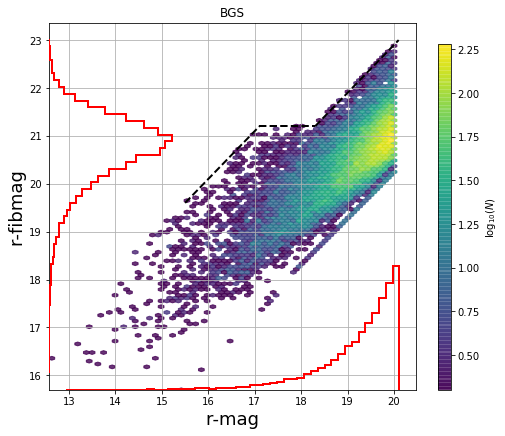

In [9]:
rmag_fibmag_density(targets[bgs], 'BGS', otherCat=False, MASK=None, Cpar=None, 
                    CparName=None, log=True, fmc=True)